In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')
import sys 
sys.path.append("/scratch/izar/kapps/DEX-Cyclic-Arbitrage/")
from config.get import cfg
from tensorflow import keras
from tensorflow.keras import layers
# import autoencoders

2022-01-05 11:32:54.107774: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-05 11:32:54.107809: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [32]:
X_train = np.load(cfg['files']["raw_train_features"])
X_test  = np.load(cfg['files']["raw_test_features"])
print(f"shapes : X_train={X_train.shape},X_test={X_test.shape}")

shapes : X_train=(2698, 3, 600, 2),X_test=(675, 3, 600, 2)


In [33]:
def model():
    model_name = "linear_with_reshape"
    in_shape = (3,600, 2) 
    # build encoder
    input_layer = keras.Input(shape=in_shape)
    x = layers.Reshape([in_shape[0]*in_shape[1]*in_shape[2]])(input_layer)
    x = layers.Dense(600,  activation='elu')(x)
    x = layers.Dense(100,  activation='elu')(x)
    x = layers.Dense(600,  activation='elu')(x)
    x = layers.Dense(in_shape[0]*in_shape[1]*in_shape[2],  activation='elu')(x)
    output_layer =layers.Reshape(in_shape)(x)
    
    
    # combine encoder and decoder
    autoencoder = keras.Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error',)
    return model_name ,autoencoder

In [34]:
_,autoencoder = model()
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 3, 600, 2)]       0         
                                                                 
 reshape_14 (Reshape)        (None, 3600)              0         
                                                                 
 dense_25 (Dense)            (None, 600)               2160600   
                                                                 
 dense_26 (Dense)            (None, 100)               60100     
                                                                 
 dense_27 (Dense)            (None, 600)               60600     
                                                                 
 dense_28 (Dense)            (None, 3600)              2163600   
                                                                 
 reshape_15 (Reshape)        (None, 3, 600, 2)         0   

In [ ]:
hist = autoencoder.fit(X_train, X_train,epochs=150)

Epoch 1/150
85/85 [==============================] - 10s 112ms/step - loss: 0.3725
Epoch 2/150
85/85 [==============================] - 10s 114ms/step - loss: 0.2018
Epoch 3/150
85/85 [==============================] - 9s 112ms/step - loss: 0.1652
Epoch 4/150
85/85 [==============================] - 10s 114ms/step - loss: 0.1470
Epoch 5/150
85/85 [==============================] - 10s 114ms/step - loss: 0.1358
Epoch 6/150
85/85 [==============================] - 10s 113ms/step - loss: 0.1263
Epoch 7/150
85/85 [==============================] - 10s 114ms/step - loss: 0.1189
Epoch 8/150
85/85 [==============================] - 10s 113ms/step - loss: 0.1128
Epoch 9/150
85/85 [==============================] - 10s 114ms/step - loss: 0.1144
Epoch 10/150
85/85 [==============================] - 10s 112ms/step - loss: 0.1085
Epoch 11/150
85/85 [==============================] - 10s 112ms/step - loss: 0.1014
Epoch 12/150
85/85 [==============================] - 10s 113ms/step - loss: 0.0985
Ep

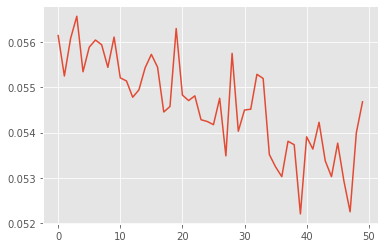

In [30]:
plt.plot(hist.history["loss"])
plt.show()

# testing 

In [31]:
def mean_squared_error(x,y):
    return np.sum((x-y)**2)/x.size

train_pred = autoencoder(X_train).numpy()
test_pred  = autoencoder(X_test).numpy()

print(f"MSE train : {mean_squared_error(train_pred,X_train)} \nMSE test  : {mean_squared_error(test_pred,X_test)}")

MSE train : 0.051664736973624656 
MSE test  : 0.08055312499386301
